In [6]:
import os
import pandas as pd
import numpy as np
import requests
from io import StringIO  

# CONFIGURATION
API_KEY      = '***'
symbol       = 'AAPL'
data_dir     = os.path.join('..','data')                
raw_csv      = os.path.join(data_dir, f'{symbol}_raw.csv')
output_csv   = os.path.join(data_dir, f'{symbol}_with_indicators.csv')
os.makedirs(data_dir, exist_ok=True)


def fetch_indicator(symbol, indicator):
    """Try to fetch an indicator CSV; return DataFrame or None."""
    url = (
        "https://www.alphavantage.co/query"
        f"?function={indicator}&symbol={symbol}"
        "&interval=daily&time_period=14&series_type=close"
        f"&apikey={API_KEY}&datatype=csv"
    )
    r = requests.get(url)
    text = r.text
    # If AV returns a JSON “Information” or “Error Message”, bail out
    if "Information" in text or "Error Message" in text:
        print(f"{indicator} fetch failed: {text.splitlines()[0]}")
        return None
    return pd.read_csv(StringIO(text)) 

# Load raw data
raw_df = pd.read_csv(raw_csv, parse_dates=['timestamp'])

# Fetch RSI & MACD (or None)
rsi_df  = fetch_indicator(symbol, 'RSI')
macd_df = fetch_indicator(symbol, 'MACD')

# Convert and merge RSI
if rsi_df is not None and 'time' in rsi_df.columns:
    rsi_df['time'] = pd.to_datetime(rsi_df['time'])
    raw_df = raw_df.merge(
        rsi_df[['time','RSI']],
        left_on='timestamp', right_on='time',
        how='left'
    ).drop(columns=['time'])
else:
    print("Simulating RSI")
    raw_df['RSI'] = np.random.uniform(30, 70, size=len(raw_df))

# Convert and merge MACD
if macd_df is not None and 'time' in macd_df.columns:
    macd_df['time'] = pd.to_datetime(macd_df['time'])
    raw_df = raw_df.merge(
        macd_df[['time','MACD_Signal','MACD_Hist','MACD']],
        left_on='timestamp', right_on='time',
        how='left'
    ).drop(columns=['time'])
else:
    print("Simulating MACD")
    raw_df['MACD']        = np.random.normal(0, 1,   len(raw_df))
    raw_df['MACD_Hist']   = np.random.normal(0, 0.5, len(raw_df))
    raw_df['MACD_Signal'] = np.random.normal(0, 0.7, len(raw_df))

# Save the merged data
raw_df.to_csv(output_csv, index=False)
print(f"Saved merged data with indicators to {output_csv}")


⚠️  MACD fetch failed: {
⚠️  Simulating MACD
✅ Saved merged data with indicators to ..\data\AAPL_with_indicators.csv


In [7]:
import pandas as pd

# Get the data
df = pd.read_csv('../data/AAPL_with_indicators.csv', parse_dates=['timestamp'])

# Calculate the EMAs
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line and Signal Line
df['MACD_Line'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()

# MACD Histogram
df['MACD_Histogram'] = df['MACD_Line'] - df['Signal_Line']

# Save it
df.to_csv('../data/AAPL_with_manual_macd.csv', index=False)

print("✅ Calculated and saved manual MACD values.")


✅ Calculated and saved manual MACD values.


19:28:14 - cmdstanpy - INFO - Chain [1] start processing
19:28:15 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecast saved to ../data/AAPL_forecast.csv and plot to ../plots/AAPL_forecast.png


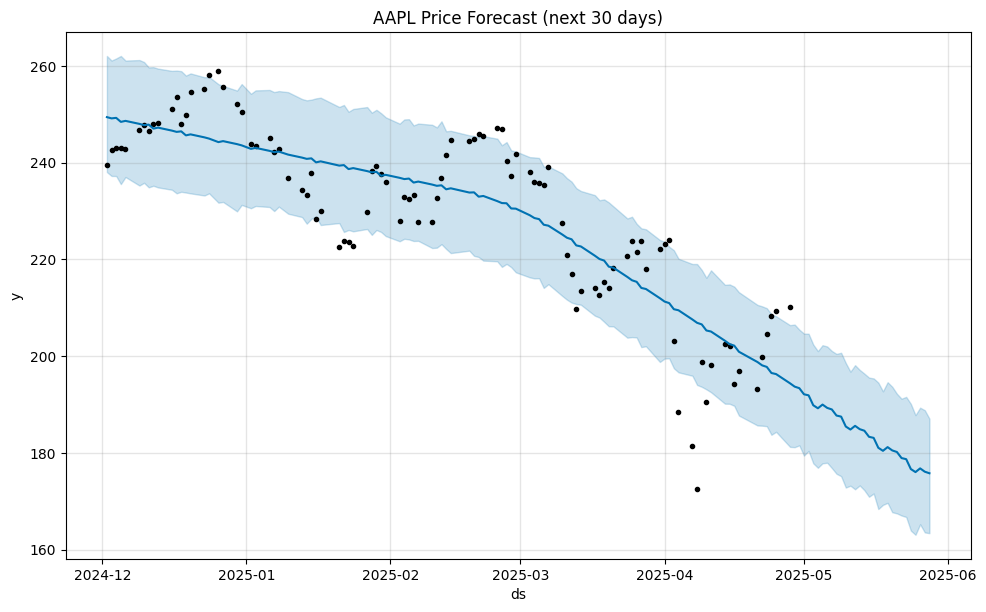

In [11]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Load the merged data
merged_df = pd.read_csv('../data/AAPL_with_indicators.csv', parse_dates=['timestamp'])

# Prepare data for Prophet
fc_df = merged_df[['timestamp', 'close']].rename(columns={'timestamp':'ds','close':'y'})

# Initialize & fit
model = Prophet(daily_seasonality=True)
model.fit(fc_df)

# Create future dataframe (next 30 days)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot & save
fig = model.plot(forecast)
plt.title("AAPL Price Forecast (next 30 days)")
fig.savefig("../plots/AAPL_forecast.png")   # corrected path
forecast.to_csv('../data/AAPL_forecast.csv', index=False)

print("Forecast saved to ../data/AAPL_forecast.csv and plot to ../plots/AAPL_forecast.png")
